In [2]:
import math
import pypoman
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import random
from scipy.stats import bernoulli, uniform, chi2
import numpy as np
from scipy.stats.mstats import gmean
from numpy.testing import assert_allclose
from iteround import saferound
from utils import Bets, Allocations, Weights, mart, lower_confidence_bound, global_lower_bound,\
    intersection_mart, plot_marts_eta, construct_eta_grid, union_intersection_mart, selector,\
    construct_eta_grid_plurcomp, construct_vertex_etas, simulate_comparison_audit, random_truncated_gaussian,\
    PGD, negexp_ui_mart
np.random.seed(123456789)

In [11]:
%%time
alt_grid = [0.51, 0.53, 0.55, 0.58, 0.60, 0.65, 0.68, 0.7, 0.75]
delta_grid = [0, 0.1, 0.5]
alpha = 0.05
eta_0 = 0.5

methods_list = ['lcb', 'uinnsm']
bets_dict = {
    "fixed":Bets.fixed, 
    "agrapa":lambda x, eta: Bets.agrapa(x, eta, c = 0.95), 
    "smooth_predictable":Bets.smooth_predictable}
bets_list = ["fixed", "agrapa", "smooth_predictable"]
allocations_dict = {
    "round_robin":Allocations.round_robin, 
    "larger_means":Allocations.more_to_larger_means, 
    "proportional_to_mart":Allocations.proportional_to_mart,
    "predictable_kelly":Allocations.predictable_kelly}
allocations_list = ["round_robin", "larger_means", "proportional_to_mart", "predictable_kelly"]

K = 2
N = [30, 30]
results = []

for alt, delta, method, bet, allocation in itertools.product(alt_grid, delta_grid, methods_list, bets_list, allocations_list):
    means = [alt - 0.5*delta, alt + 0.5*delta]
    calX = [np.array([0, means[0]]),np.array([0, means[1]])]
    samples = [np.ones(N[0]) * means[0], np.ones(N[1]) * means[1]]
    eta_grid, calC, ub_calC = construct_eta_grid(eta_0, calX, N) 
    
    if method == 'lcb':
        if bet == 'uniform_mixture' or allocation in ['proportional_to_mart','predictable_kelly']:
            stopping_time = None
        else: 
            lower_bound = global_lower_bound(
                x = samples, 
                N = N, 
                lam_func = bets_dict[bet], 
                allocation_func = allocations_dict[allocation],
                alpha = alpha, 
                breaks = 1000,
                WOR = True)
            stopping_time = np.where(any(lower_bound > eta_0), np.argmax(lower_bound > eta_0), np.sum(N))
    elif method == 'uinnsm':
        if bet == 'uniform_mixture':
            mart = union_intersection_mart(
                        x = samples, 
                        N = N,
                        etas = eta_grid, 
                        lam_func = None, 
                        allocation_func = allocations_dict[allocation],
                        mixture = "uniform",
                        combine = "product", 
                        log = False,
                        WOR = True)[0]
        else: 
            mart = union_intersection_mart(
                        x = samples, 
                        N = N,
                        etas = eta_grid, 
                        lam_func = bets_dict[bet], 
                        allocation_func = allocations_dict[allocation],
                        combine = "product", 
                        log = False,
                        WOR = True)[0]
        stopping_time = np.where(any(mart > 1/alpha), np.argmax(mart > 1/alpha), np.sum(N))
    data_dict = {
        "alt":alt, 
        "delta":delta, 
        "method":str(method),
        "bet":str(bet), 
        "allocation":str(allocation),
        "stopping_time":stopping_time}
    results.append(data_dict)
results = pd.DataFrame(results)
results.to_csv("point_mass_results.csv", index = False)

/Users/Jake/Dropbox/RLAs/UI-NNSMs/Code/utils.py:259: RuntimeWarning: invalid value encountered in log
  mart = np.insert(np.cumsum(np.log(1 + lam_func(x, eta_t) * (x - eta_t))), 0, 0)
/Users/Jake/Dropbox/RLAs/UI-NNSMs/Code/utils.py:74: RuntimeWarning: divide by zero encountered in true_divide
  lam_trunc = np.maximum(0, np.minimum(lam_untrunc, c/eta))
/Users/Jake/Dropbox/RLAs/UI-NNSMs/Code/utils.py:259: RuntimeWarning: divide by zero encountered in log
  mart = np.insert(np.cumsum(np.log(1 + lam_func(x, eta_t) * (x - eta_t))), 0, 0)
/Users/Jake/Dropbox/RLAs/UI-NNSMs/Code/utils.py:74: RuntimeWarning: divide by zero encountered in double_scalars
  lam_trunc = np.maximum(0, np.minimum(lam_untrunc, c/eta))


CPU times: user 59.8 s, sys: 353 ms, total: 1min
Wall time: 1min


In [5]:
#all results
print(results.to_string())

     alt  delta                 bet wright uinnsm_product uinnsm_fisher uinnsm_vertex uinnsm_uniform
0   0.55    0.0               fixed     57             46            54            60             60
1   0.55    0.0              agrapa     53             42            49            60             60
2   0.55    0.0  smooth_predictable     54             38            48            60             60
3   0.55    0.1               fixed     57             48            54            60             60
4   0.55    0.1              agrapa     54             42            50            60             60
5   0.55    0.1  smooth_predictable     54             40            52            60             60
6   0.55    0.5               fixed     55             46            54            60             60
7   0.55    0.5              agrapa     55             45            52            60             60
8   0.55    0.5  smooth_predictable     53             40            50            60      

In [2]:
%%time
N = [100, 100]

grand_means = [0.75]
stratum_gaps = [0.0, 0.5]

bets_dict = {"fixed":Bets.fixed, "agrapa":Bets.agrapa, "smooth_predictable":Bets.smooth_predictable}
bets_list = ["fixed", "agrapa", "smooth_predictable"]

results = []
for grand_mean, gap, bet in itertools.product(grand_means, stratum_gaps, bets_list):
    A_c = [grand_mean - 0.5*gap, grand_mean + 0.5*gap]
    p_1 = [0.0, 0.0]
    p_2 = [0.0, 0.0]
    stopping_time_uinnsm = simulate_comparison_audit(
        N, A_c, p_1, p_2,
        lam_func = bets_dict[bet],
        allocation_func = Allocations.round_robin,
        method = "ui-nnsm",
        combine = "product",
        reps = 1,
        WOR = True)[0]
    stopping_time_lcb = simulate_comparison_audit(
        N, A_c, p_1, p_2,
        lam_func = bets_dict[bet],
        allocation_func = Allocations.round_robin,
        method = "lcbs",
        reps = 1,
        WOR = True)[0]
    data_dict = {
        "A_c":grand_mean,
        "stratum_gap":gap,
        "A_c_1":A_c[0],
        "A_c_2":A_c[1],
        "bet":str(bet),
        "stopping_time_uinnsm":stopping_time_uinnsm,
        "stopping_time_lcb":stopping_time_lcb
    }
    results.append(data_dict)
results = pd.DataFrame(results)

/Users/Jake/Dropbox/RLAs/UI-NNSMs/Code/utils.py:192: RuntimeWarning: invalid value encountered in log
  mart = np.insert(np.cumsum(np.log(1 + lam_func(x, eta) * (x - eta_t))), 0, 0)
/Users/Jake/Dropbox/RLAs/UI-NNSMs/Code/utils.py:192: RuntimeWarning: divide by zero encountered in log
  mart = np.insert(np.cumsum(np.log(1 + lam_func(x, eta) * (x - eta_t))), 0, 0)


CPU times: user 11.5 s, sys: 28.5 ms, total: 11.6 s
Wall time: 11.6 s


In [2]:
%%time
K = 5
N = [1000 for _ in range(K)]
delta = 0.3
shifts = np.linspace(-0.5,0.5,K)
deltas = shifts * delta
x = [random_truncated_gaussian(0.5 + deltas[k], 0.05, N[k]) for k in range(K)]

uinnsm = negexp_ui_mart(x, N, Allocations.round_robin, 0.5)
uinnsm

CPU times: user 41.4 s, sys: 210 ms, total: 41.6 s
Wall time: 41.6 s


[1,
 -0.39621098496690754,
 -0.7867324680733172,
 -0.7893714242464627,
 -0.3965934276068457,
 0.2790719931809071,
 0.13617195839852683,
 -0.011723733268842018,
 -0.09491601453125753,
 0.0544651419330352,
 0.4812007326754085,
 0.3667021130533245,
 0.24276605147288888,
 0.14303685457273152,
 0.2569104853938251,
 0.6044432820752461,
 0.41587625093354186,
 0.37714245184631123,
 0.27801173169576643,
 0.40519703400711504,
 0.5740758486923044,
 0.44622035363365875,
 0.35229752048450125,
 0.417650089544953,
 0.5207488956376094,
 0.715521427160865,
 0.5217717351501241,
 0.49115081025321117,
 0.43696173205477273,
 0.5643193069705419,
 0.7333418113726855,
 0.6574305650091945,
 0.5926563337367077,
 0.5280918112723776,
 0.6222468339140812,
 0.7289228062949346,
 0.6618968250842487,
 0.6403583599692891,
 0.6836740517438478,
 0.7499494364158115,
 0.8411434146930643,
 0.7580746859852575,
 0.767484315382509,
 0.7695659014433234,
 0.8387976802155175,
 1.001874119011103,
 0.9281807938467375,
 0.9384385757

In [30]:
K = 3
lam_grids = K * [np.linspace(0.01,0.99,5)]
mixing_dist = np.array(list(itertools.product(*lam_grids)))
mixing_dist

array([[0.01 , 0.01 , 0.01 ],
       [0.01 , 0.01 , 0.255],
       [0.01 , 0.01 , 0.5  ],
       [0.01 , 0.01 , 0.745],
       [0.01 , 0.01 , 0.99 ],
       [0.01 , 0.255, 0.01 ],
       [0.01 , 0.255, 0.255],
       [0.01 , 0.255, 0.5  ],
       [0.01 , 0.255, 0.745],
       [0.01 , 0.255, 0.99 ],
       [0.01 , 0.5  , 0.01 ],
       [0.01 , 0.5  , 0.255],
       [0.01 , 0.5  , 0.5  ],
       [0.01 , 0.5  , 0.745],
       [0.01 , 0.5  , 0.99 ],
       [0.01 , 0.745, 0.01 ],
       [0.01 , 0.745, 0.255],
       [0.01 , 0.745, 0.5  ],
       [0.01 , 0.745, 0.745],
       [0.01 , 0.745, 0.99 ],
       [0.01 , 0.99 , 0.01 ],
       [0.01 , 0.99 , 0.255],
       [0.01 , 0.99 , 0.5  ],
       [0.01 , 0.99 , 0.745],
       [0.01 , 0.99 , 0.99 ],
       [0.255, 0.01 , 0.01 ],
       [0.255, 0.01 , 0.255],
       [0.255, 0.01 , 0.5  ],
       [0.255, 0.01 , 0.745],
       [0.255, 0.01 , 0.99 ],
       [0.255, 0.255, 0.01 ],
       [0.255, 0.255, 0.255],
       [0.255, 0.255, 0.5  ],
       [0.

In [21]:
global_mean = 0.7
delta = 0.3
K = 5
N = [int(1000/K) for _ in range(K)]
w = N/np.sum(N)
shifts = np.linspace(-0.5,0.5,K)
deltas = shifts * delta
sd = 0.05

x_unstrat = np.zeros(np.sum(N))
for i in range(np.sum(N)):
    rand_k =  np.random.choice(np.arange(K), size = 1, p = w)
    x_unstrat[i] = random_truncated_gaussian(mean = global_mean + deltas[rand_k], sd = sd, size = 1)

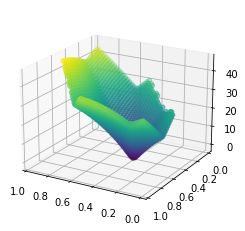

In [2]:
K = 3
N = [100 for _ in range(K)]
delta = 0.3
shifts = np.linspace(-0.5,0.5,K)
deltas = shifts * delta
x = [random_truncated_gaussian(0.5 + deltas[k], 0.05, N[k]) for k in range(K)]

plot_marts_eta(x = x,
               N = N, 
               #lam_func = Bets.smooth_predictable, 
               mixture = "vertex",
               allocation_func = Allocations.proportional_round_robin,
               combine = "product",
               res = 2e-2)

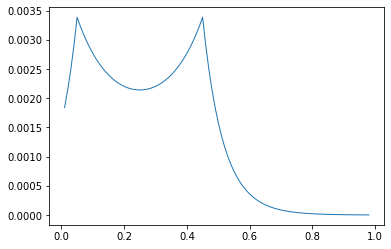

In [8]:
#fisher combining isn't even unimodal... i.e. it seems like it will be difficult to scale
plot_marts_eta(
    x = samples, 
    N = N, 
    lam_func = Bets.fixed, 
    allocation_func = Allocations.round_robin,
    combine = "fisher", 
    theta_func = Weights.fixed, 
    log = False)